In [103]:
import pandas as pd
import os 
from pathlib import Path
from bertopic import BERTopic
import re 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import plotly.io as pio

import pandas as pd
import os 
from pathlib import Path
from nltk.corpus import stopwords

from preprocessing.preprocessing_module import full_cleaning_pipeline


METAPROJECT_NAME = 'TopicModelling_META'
SUBPROJECT_NAME = 'TopMod_pipeline'



DATASET_NAME = "Handwritten_CombinedTranslation.csv"
HIGH_SENSORY = True #If False, corresponds to deep listening experience (no flicker)
# CONDITION = 'highsensory' if HIGH_SENSORY else 'deeplistening'
CONDITION = 'handwritten'
print(f'Condition : "{CONDITION}"')




PROJDIR = os.path.expanduser(f"~/projects/{METAPROJECT_NAME}")
DATADIR = os.path.join(PROJDIR,f'DATA/{DATASET_NAME}')
CODEDIR = os.path.join(PROJDIR,f'{SUBPROJECT_NAME}')



%matplotlib inline

Condition : "handwritten"


Parameters for BERTopic

https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html

In [104]:
from transformers.pipelines import pipeline

#Parameters for Topic Modelling
remove_stopwords = True

embedding_model = "all-MiniLM-L6-v2" #which transformer-based model to use to create embeddings of the reports
# embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
# topic_model = BERTopic(embedding_model=embedding_model)
min_topic_size = 15 
min_topic_size_range = range(35, 5, -5)  # Adjust the range as per your requirement

Import Data

In [105]:
# Raw text data
dataset = pd.read_csv(DATADIR)['reflection_answer']
reports = pd.DataFrame(dataset[dataset.notna() & (dataset != '')].reset_index(drop=True)) #delete empty rows
reports

,reflection_answer
0,Felt like how I feel in the split second befor...
1,"Surreal\nConnection to other dimension, in a g..."
2,"\r\nDrifted into different stories, saw intens..."
3,"At the session start, I could only see orange ..."
4,Patterns were the main ‘visual’ when my eyes w...
...,...
3657,"I had a brief, very tangible experience, a vis..."
3658,I could see fractal patterns like I was in a k...
3659,"Vivid waves , transportation at speed from sun..."
3660,Felt a connection with the subconscious mind. ...


In [106]:
#Preprocessed text data
#check if preprocessed dataset already exist, and if not, create a preprocessed dataset and store it in the preprocessing folder

base_name, ext = os.path.splitext(DATASET_NAME)
new_path = f"{base_name}_{CONDITION}_preprocessed_stopwords{ext}" if remove_stopwords else f"{base_name}_{CONDITION}_preprocessed{ext}"
preproc_path = os.path.join(PROJDIR, f'DATA/preprocessed/{new_path}')

# Check if the preprocessed file already exists
if not os.path.exists(preproc_path):
    # If not, create it using the full_cleaning_pipeline function and save it
    reports = full_cleaning_pipeline(reports, 'reflection_answer',text_clean_flag=remove_stopwords)
    reports = reports.reset_index(drop=True)
    
    # Ensure the directory exists before saving the file
    os.makedirs(os.path.dirname(preproc_path), exist_ok=True)
    
    reports.to_csv(preproc_path, index=False)
else:
    reports = pd.read_csv(preproc_path)
    print(f"The preprocessed file already exists at: {preproc_path}")

data = reports['reflection_answer']

print('N={} reports (HighSensory = {})'.format(len(reports),HIGH_SENSORY))
reports.head()

N=3633 reports (HighSensory = True)


,reflection_answer
0,Felt like feel split second falling asleep
1,Unreal Connection dimension galaxy peace grati...
2,Drifted different stories saw intense colours ...
3,It session start could see orange blue orange ...
4,Patterns main visual eyes closed Not triangles...


## BERTopic

https://miro.medium.com/v2/resize:fit:4800/format:webp/0*DxAqCqx6dzg0KQlg.png

In [107]:
# finds the maximum min_topic_size that doesn't cause an error

def find_max_topics(data, embedding_model, min_topic_size_range):
    max_topics = 0
    optimal_min_topic_size = 0
    
    for min_size in min_topic_size_range:
        try:
            model = BERTopic(language="english", 
                             calculate_probabilities=True, 
                             verbose=True,
                             nr_topics='auto',
                             embedding_model=embedding_model,
                             min_topic_size=min_size)
            
            topics, _ = model.fit_transform(data)
            num_topics = len(set(topics))  # Calculate the number of unique topics
            
            if num_topics > max_topics:
                max_topics = num_topics
                optimal_min_topic_size = min_size
                
            print(f"Min_topic_size: {min_size}, Num Topics: {num_topics}")
            
        except ValueError as e:
            print(f"Error with min_topic_size: {min_size}. Error message: {str(e)}")
            continue
        
    return max_topics, optimal_min_topic_size







if not min_topic_size:
    max_topics, optimal_min_topic_size = find_max_topics(data, embedding_model, min_topic_size_range)
    print(f"Maximum number of topics: {max_topics} found with min_topic_size: {optimal_min_topic_size}")
else:
    optimal_min_topic_size = min_topic_size

print(f"Setting min_topic_size = {optimal_min_topic_size}")

Setting min_topic_size = 15


### Training the BERT model

In [108]:
from bertopic import BERTopic

model = BERTopic(language="english", calculate_probabilities=True, verbose=True,nr_topics='auto',embedding_model=embedding_model,min_topic_size=optimal_min_topic_size) #The higher the value of min_topic_size, the more specific the topics will be
topics, probs = model.fit_transform(reports['reflection_answer']) #Fit model to data : topics are the topic labels for each document, probs are the probabilities of each topic for each document
model.visualize_topics() #Visualize topics


Batches:   0%|          | 0/114 [00:00<?, ?it/s]

2023-10-13 15:24:08,895 - BERTopic - Transformed documents to Embeddings
2023-10-13 15:24:16,424 - BERTopic - Reduced dimensionality
2023-10-13 15:24:16,607 - BERTopic - Clustered reduced embeddings
2023-10-13 15:24:16,749 - BERTopic - Reduced number of topics from 26 to 26


### Topic extraction and representation

In [113]:
topic_freq = model.get_topic_freq().head() #Get the frequency of each topic
freq = model.get_topic_info() #see the most representative terms for each topic
print("N number of topics: ",len(freq))
print(freq.head())


N number of topics:  26
   Topic  Count                                   Name  \
0     -1   2228                -1_like_felt_colours_it   
1      0    204                 0_felt_life_like_peace   
2      1    172               1_saw_shapes_like_moving   
3      2    119     2_relaxed_experience_relaxing_felt   
4      3    115  3_kaleidoscope_colours_sometimes_like   

                                      Representation  \
0  [like, felt, colours, it, experience, saw, lig...   
1  [felt, life, like, peace, it, space, love, uni...   
2  [saw, shapes, like, moving, seen, colours, cen...   
3  [relaxed, experience, relaxing, felt, relax, m...   
4  [kaleidoscope, colours, sometimes, like, patte...   

                                 Representative_Docs  
0  [Mostly calming relaxing felt copy safe The li...  
1  [felt quite calm experience quite effective Th...  
2  [felt like dream floating space time saw lots ...  
3  [first started feel relaxed concentrating brea...  
4  [Started bri

## Prileminary visualisation

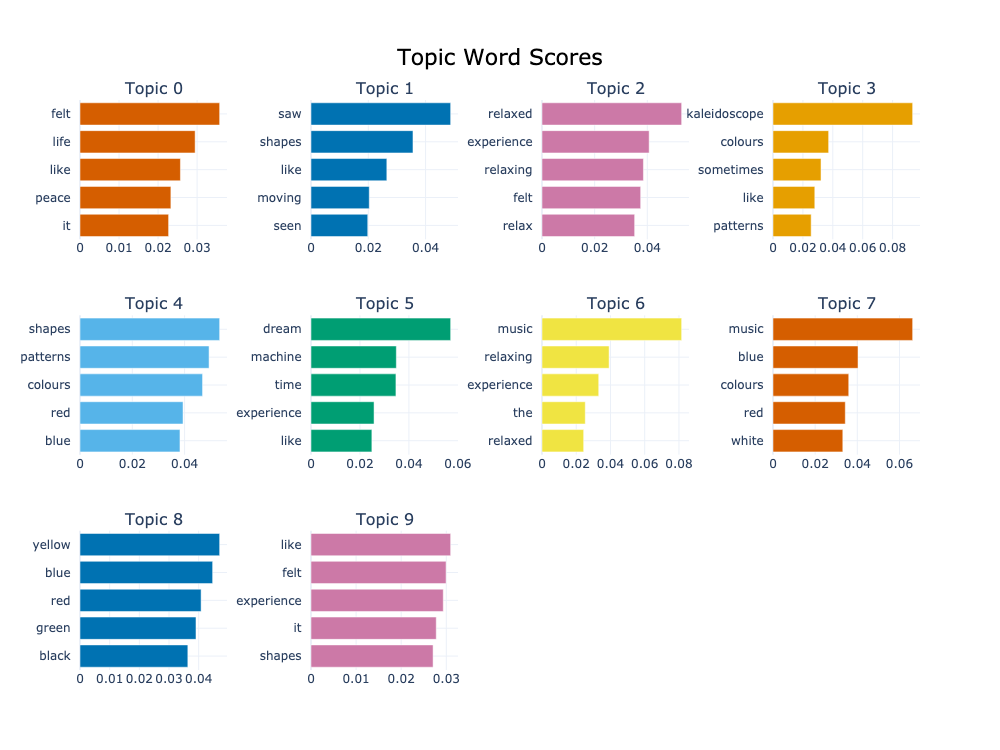

In [114]:
outputs_path = os.path.join(CODEDIR,f'BERT_outputs/{CONDITION}')

# Save the barchart visualization to a file
fig = model.visualize_barchart(top_n_topics=10) #Visualize the top 10 topics
save_path_barchart = os.path.join(outputs_path,'BERT_barchart.png')
fig.write_image(save_path_barchart)

# # Import the Image and display functions from IPython
# from IPython.display import Image, display

# Display the saved image
display(Image(filename=save_path_barchart))

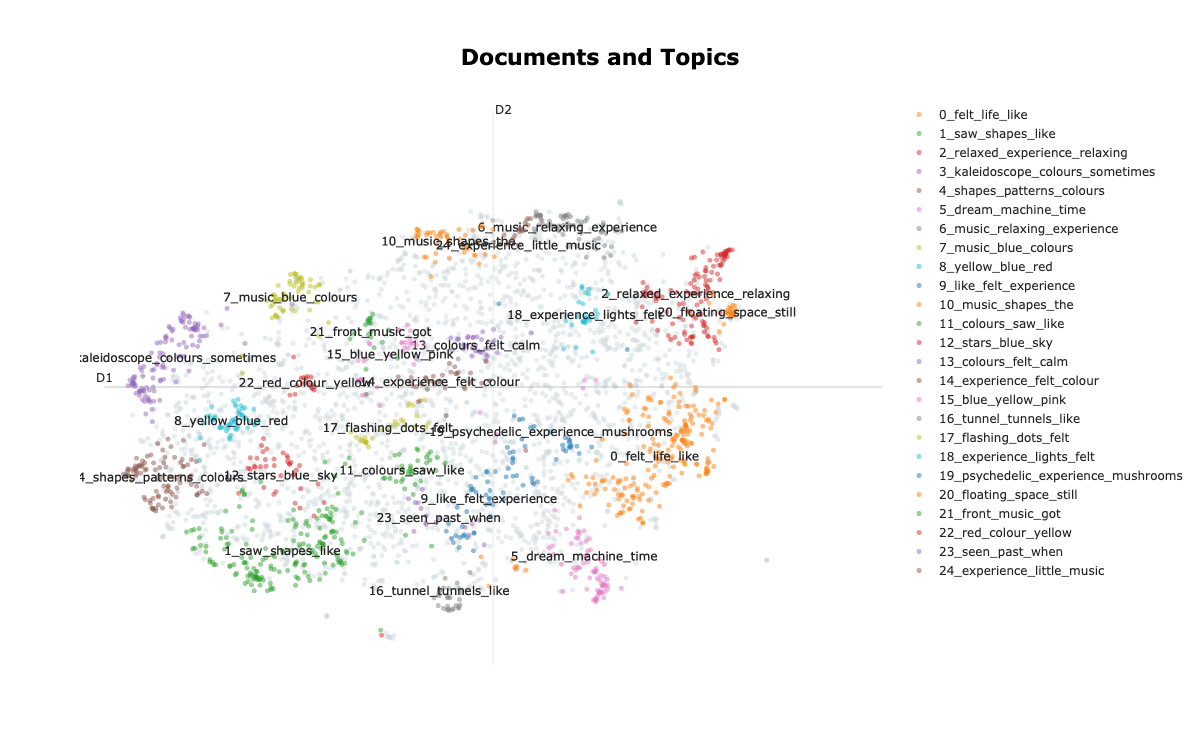

In [115]:
# Save the barchart visualization to a file
fig = model.visualize_documents(reports['reflection_answer'])
save_path_cloud = os.path.join(outputs_path,'BERT_cloud_{}.png'.format(CONDITION))
fig.write_image(save_path_cloud)

# # Import the Image and display functions from IPython
# from IPython.display import Image, display

# Display the saved image
display(Image(filename=save_path_cloud))

In [117]:
model.visualize_heatmap(top_n_topics=40) #Visualize the top 10 topics as a heatmap

In [118]:
# Visualise topic distributions to understand how confident BERTopic is that certain topics can be found in a document
model.visualize_distribution(probs[200], min_probability=0.015)

In [123]:
model.visualize_hierarchy(top_n_topics=50)